In [ ]:
%matplotlib inline
!pip install keras>=2.9.0
!pip install keras_preprocessing
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow_addons.layers import *
from tensorflow.keras.losses import MSE
from PIL import Image
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import glob
import cv2
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 392.9 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.0 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/Project/'
train_path_A = '/content/gdrive/MyDrive/Project/trainA/'
train_path_B = '/content/gdrive/MyDrive/Project/trainB/'



def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images
def tf_pipeline(dataset):
    dataset = tf.data.Dataset.from_tensor_slices({'image':dataset})
    dataset = dataset.map(preprocess)
    dataset = dataset.repeat().shuffle(100).batch(16).prefetch(1)
    return dataset
    
def tf_data(path):
    trainingA = []
    for x in glob.glob(path+'trainA/*'):
        image = Image.open(x)
        image = image.resize((128,128))
        trainingA.append(np.array(image))
        
    trainingB = []
    for x in glob.glob(path+'trainB/*'):
        image = Image.open(x)
        image = image.resize((128,128))
        trainingB.append(np.array(image))
    a,b = tf_pipeline(trainingA),tf_pipeline(trainingB)
    return a.__iter__(),b.__iter__()


Mounted at /content/gdrive


In [ ]:
trainA,trainB = tf_data(path)

In [ ]:
input_dim = (128,128,3) #input/output image dimension
depth = 4               #network depth  
kernel = 3              #kernel size for Conv2D
n_batch = 16            #batch_size
epochs = 50
steps = round(1500/n_batch) #steps per epoch, we have ~1500 samples per domain so calculating steps using it

In [ ]:
def discriminator(input_dim,depth,kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
            layers.append(Conv2D(16*i,kernel_size=kernel))
            layers.append(InstanceNormalization())
            layers.append(Activation('relu'))
            layers.append(Dropout(0.2))
    layers.append(Conv2D(1,kernel_size=kernel))
    model = Sequential(layers)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())
    return model
discriminator_A = discriminator(input_dim,depth,kernel)
discriminator_B = discriminator(input_dim,depth,kernel)

In [ ]:
def generator(input_dim, depth, kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [128,128]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(3,kernel_size=1,activation=None))
    model = Sequential(layers)
    return model
generator_A_B = generator(input_dim,depth,kernel)
generator_B_A = generator(input_dim,depth,kernel)

In [ ]:
def composite_model(g1,d,g2,image_dim):
    g1.trainable = True
    g2.trainable = False
    d.trainable = False
    
    #Adversarial loss 
    input_img = Input(shape=input_dim)
    g1_out = g1(input_img)
    d_out = d(g1_out)
    
    #identity loss
    input_id = Input(shape=input_dim)
    g1_out_id = g1(input_id)
    
    #Cycle Loss, Forward cycle
    g2_out = g2(g1_out)
    
    #Cycle Loss, Backward-cycle
    g2_out_id = g2(input_id)
    output_g1 = g1(g2_out_id)
    
    model = Model([input_img,input_id],[d_out, g1_out_id, g2_out, output_g1])
    model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=tf.keras.optimizers.Adam())
    return model
composite_A_B = composite_model(generator_A_B, discriminator_B, generator_B_A, input_dim)
composite_B_A = composite_model(generator_B_A, discriminator_A, generator_A_B, input_dim)

In [ ]:
def generate_real(dataset, n_batch,patch_size):
    labels = np.ones((n_batch,patch_size,patch_size,1))
    return dataset,labels
def generate_fake(dataset,g,patch_size):
    predicted = g(dataset)
    labels = np.zeros((n_batch,patch_size,patch_size,1))
    return predicted,labels

In [ ]:
checkpoint_dir = './cyclegan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_A_B=generator_A_B, generator_B_A=generator_B_A,discriminator_A=discriminator_A,discriminator_B=discriminator_B,composite_A_B=composite_A_B, composite_B_A=composite_B_A)
manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

In [ ]:
def train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, batch_size, steps,n_patch):
    
    for epoch in range(1,epochs):
        for step in range(1,steps):
            print(epoch,step)
            
            x_real_A, y_real_A = generate_real(next(trainA),n_batch,n_patch)
            x_real_B, y_real_B = generate_real(next(trainB),n_batch,n_patch)
            
            x_fake_A, y_fake_A = generate_fake(x_real_B, generator_B_A,n_patch)
            x_fake_B, y_fake_B = generate_fake(x_real_A, generator_A_B,n_patch)
            
            g_A_B_loss,_,_,_,_ = composite_A_B.train_on_batch([x_real_A,x_real_B],[y_real_B,x_real_B, x_real_A, x_real_B])
            disc_A_real_loss = discriminator_A.train_on_batch(x_real_A, y_real_A)
            disc_A_fake_loss = discriminator_A.train_on_batch(x_fake_A, y_fake_A)
            
            g_B_A_loss,_,_,_,_ = composite_B_A.train_on_batch([x_real_B,x_real_A],[y_real_A,x_real_A, x_real_B, x_real_A])
            disc_B_real_loss = discriminator_B.train_on_batch(x_real_B, y_real_B)
            disc_B_fake_loss = discriminator_B.train_on_batch(x_fake_B, y_fake_B)
            
            print('g_A_B_loss',g_A_B_loss)
            print('g_B_A_loss',g_B_A_loss)
            
            manager.save()
train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, n_batch, steps,discriminator_A.output_shape[1])

Streaming output truncated to the last 5000 lines.
g_A_B_loss 2.3610053062438965
g_B_A_loss 2.425869941711426
32 9
g_A_B_loss 2.666022300720215
g_B_A_loss 2.6745870113372803
32 10
g_A_B_loss 2.696017265319824
g_B_A_loss 2.6878089904785156
32 11
g_A_B_loss 2.472691535949707
g_B_A_loss 2.5145678520202637
32 12
g_A_B_loss 2.3907384872436523
g_B_A_loss 2.534177780151367
32 13
g_A_B_loss 2.563911199569702
g_B_A_loss 2.6239352226257324
32 14
g_A_B_loss 2.398164987564087
g_B_A_loss 2.453451156616211
32 15
g_A_B_loss 2.6881613731384277
g_B_A_loss 2.856138229370117
32 16
g_A_B_loss 2.560678482055664
g_B_A_loss 2.6299116611480713
32 17
g_A_B_loss 2.388118267059326
g_B_A_loss 2.4525914192199707
32 18
g_A_B_loss 2.814725160598755
g_B_A_loss 2.7444095611572266
32 19
g_A_B_loss 2.466815948486328
g_B_A_loss 2.4665162563323975
32 20
g_A_B_loss 2.301502227783203
g_B_A_loss 2.329315185546875
32 21
g_A_B_loss 2.3563179969787598
g_B_A_loss 2.3480663299560547
32 22
g_A_B_loss 2.7286577224731445
g_B_A_loss 

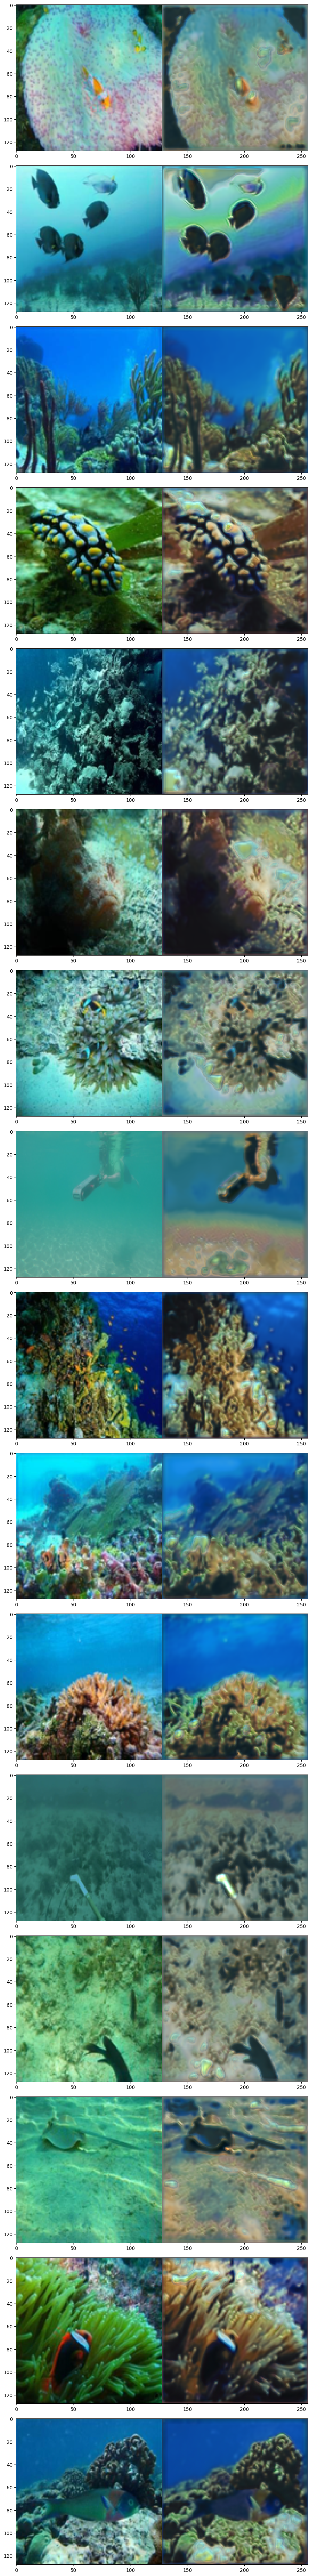

In [ ]:
#testA,testB = tf_data('test')
x_real_A, _ = generate_real(next(trainA),n_batch,0)
images_B,_ = generate_fake(x_real_A, generator_A_B,n_batch,0)
fig,ax = plt.subplots(n_batch,figsize=(75,75))
for index,img in enumerate(zip(x_real_A,images_B)):
    concat_numpy = np.clip(np.hstack((img[0],img[1])),0,1)
    ax[index].imshow(concat_numpy)
fig.tight_layout()